# RB1 cis comparison


cis comparisons for RB1 for transcriptomics, proteomics, and phosphoproteomics  
Also includes combined phosphoproteomic graph with RB1 and CCNE1 phosphoproteoimcs

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


In [6]:
# add_significance_col only works for one row.
# for now pass in a dataframe with one row for results_df
def add_significance_col(results_df, bonferroni_cutoff):
    results_df = results_df.dropna(axis=0)
    print(bonferroni_cutoff)
    for row_index, row in results_df.iterrows():
        pval = row['P_Value']
        if float(pval) <= bonferroni_cutoff:
            results_df['Significant'] = True
        else: 
            results_df['Significant'] = False
        continue
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests = None, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        if total_tests == None:
            number_of_comparisons = len(comparison_columns)
        else:
            number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        #all_comparisons_sig_col = add_significance_col(all_comparisons_df, bonferroni_cutoff)
        return all_comparisons_df
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


## Step 2: Find the mutation frequency of the gene of interest

In [7]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'RB1'

In [8]:
#FIX
#freq_mut = u.get_frequently_mutated(brain, cutoff = desired_cutoff)
#freq_mut.loc[freq_mut['Gene'] == gene]

## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps (for dataframes with multi-indexes).

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [9]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=3, flatten=True)#reduce multi columns
flatten_phospho_and_mut

Name,RB1_phosphoproteomics_S249_TAVIPINGS*PR,RB1_phosphoproteomics_S249T252_TAVIPINGS*PRT*PR,RB1_phosphoproteomics_S37_TAATAAAAAAEPPAPPPPPPPEEDPEQDS*GPEDLPLVR,RB1_phosphoproteomics_S588_DREGPTDHLES*ACPLNLPLQNNHTAADMYLSPVRSPK,RB1_phosphoproteomics_S588S608_DREGPTDHLES*ACPLNLPLQNNHTAADMYLS*PVRSPK,RB1_phosphoproteomics_S588S612_DREGPTDHLES*ACPLNLPLQNNHTAADMYLSPVRS*PK,RB1_phosphoproteomics_S588T601_DREGPTDHLES*ACPLNLPLQNNHT*AADMYLSPVRSPK,RB1_phosphoproteomics_S608_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRSPK,RB1_phosphoproteomics_S608S612_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRS*PK,RB1_phosphoproteomics_S608S612_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRS*PKK,...,RB1_phosphoproteomics_T821_ISEGLPT*PTK,RB1_phosphoproteomics_T821T826_ISEGLPT*PTKMT*PR,RB1_phosphoproteomics_T823T826_ISEGLPTPT*KMT*PR,RB1_phosphoproteomics_Y606S608_DREGPTDHLESACPLNLPLQNNHTAADMY*LS*PVRSPK,RB1_phosphoproteomics_Y771_TNILQY*ASTRPPTLSPIPHIPR,RB1_phosphoproteomics_Y813_IPGGNIYISPLKSPY*K,RB1_Mutation,RB1_Location,RB1_Mutation_Status,Sample_Status
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,-1.0400,NaN,-0.505,NaN,NaN,NaN,-0.890,NaN,-1.320,NaN,...,-0.636,NaN,-0.38100,NaN,NaN,NaN,[Splice_Site],[p.X654_splice],Single_mutation,Tumor
S002,-1.1400,NaN,0.292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.160,-0.394,NaN,NaN,NaN,NaN,[Frame_Shift_Del],[p.F117Lfs*8],Single_mutation,Tumor
S003,0.0298,-0.00284,-0.906,NaN,NaN,NaN,NaN,1.050,NaN,NaN,...,NaN,-0.156,NaN,NaN,NaN,0.944,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
S004,-1.1200,-0.33900,-0.682,NaN,NaN,-0.928,NaN,-0.515,NaN,NaN,...,NaN,NaN,-1.71000,NaN,NaN,NaN,"[Splice_Region, Splice_Site]","[p.D349=, p.X605_splice]",Multiple_mutation,Tumor
S005,0.4290,NaN,0.184,NaN,NaN,NaN,-0.328,NaN,-0.419,NaN,...,-0.799,NaN,-0.05020,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S111,-0.0532,0.10900,0.265,-0.0604,NaN,NaN,0.173,NaN,NaN,-1.2500,...,NaN,NaN,-0.24700,NaN,NaN,NaN,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal
S112,0.2480,NaN,1.700,NaN,NaN,NaN,NaN,-1.070,NaN,-0.0306,...,NaN,NaN,0.03710,NaN,NaN,NaN,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal
S113,-0.3610,NaN,0.996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.611,-1.670,NaN,NaN,NaN,NaN,[Wildtype_Normal],[No_mutation],Wildtype_Normal,Normal


In [10]:

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [11]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
#phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Doing t-test comparison for mutation status
5 significant comparisons!


,Comparison,P_Value
0,RB1_phosphoproteomics_S788_TNILQYASTRPPTLSPIPH...,0.000015
1,RB1_phosphoproteomics_T356_TLQTDSIDSFETQRT*PRK,0.000104
2,RB1_phosphoproteomics_S249_TAVIPINGS*PR,0.000291
3,RB1_phosphoproteomics_S807S811_IPGGNIYIS*PLKS*PYK,0.000583
4,RB1_phosphoproteomics_S612_DREGPTDHLESACPLNLPL...,0.000986


Graph

In [12]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
#phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df.replace(to_replace = '.TNILQYASTRPPTLSPIPHIPRS\WPYK', value = '', 
                        inplace = True, regex = True)
phospho_df.replace(to_replace = '.\DREGPTDHLESACPLNLPLQNNHTAADMYLSPVRS\WPK', value = '', 
                        inplace = True, regex = True)
phospho_df.replace(to_replace = '.TAVIPINGS\WPR', value = '', 
                        inplace = True, regex = True)
phospho_df.replace(to_replace = '.IPGGNIYIS\WPLKS\WPYK', value = '', 
                        inplace = True, regex = True)
phospho_df.replace(to_replace = '.TLQTDSIDSFETQRT\WPRK', value = '', 
                        inplace = True, regex = True)

phospho_df


,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,RB1_S788,-0.678
1,Mutated,RB1_S788,-0.152
2,Wildtype,RB1_S788,-0.239
3,Mutated,RB1_S788,-0.625
4,Wildtype,RB1_S788,-0.178
...,...,...,...
495,Wildtype,RB1_S612,-0.426
496,Wildtype,RB1_S612,0.791
497,Wildtype,RB1_S612,-0.239
498,Wildtype,RB1_S612,-0.232


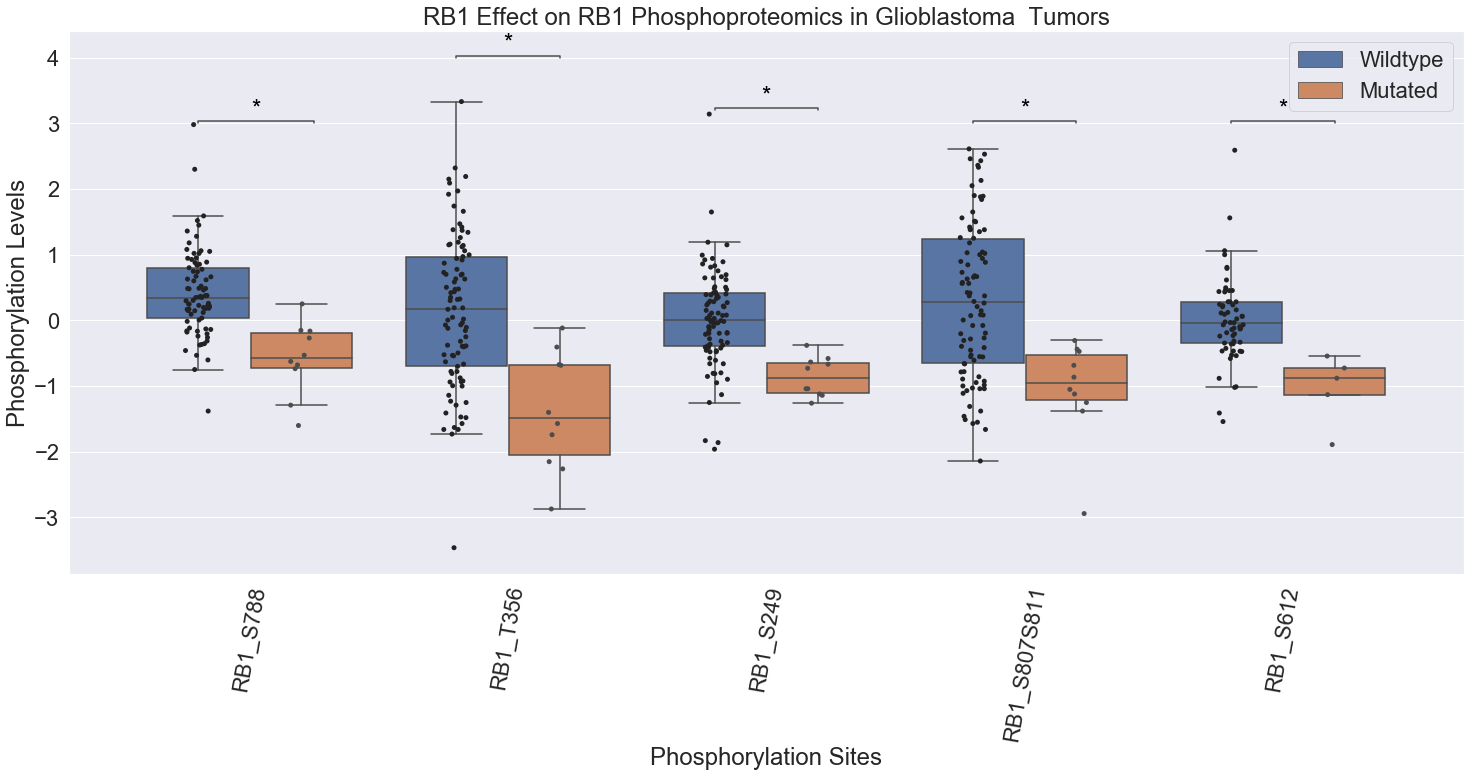

In [13]:
plt.rcParams['figure.figsize']=(25,10) #size of plot
sns.set(font_scale = 2)

cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False) 
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Glioblastoma  Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation=80)

# format legend
handles, labels = cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

#Uncomment for when any phospho site comparison is significant
# pval annotations for 
format_pval_annotation('*', x1 = -.2, x2 = .25, line_start = 3, line_height = .03)
# pval annotations for 
format_pval_annotation('*', x1 = .8, x2 = 1.2, line_start = 4, line_height = .03)
# pval annotations for
format_pval_annotation('*', x1 = 1.8, x2 = 2.2, line_start = 3.2, line_height = .03)
# pval annotations for
format_pval_annotation('*', x1 = 2.8, x2 = 3.2, line_start = 3, line_height = .03)
# pval annotations for
format_pval_annotation('*', x1 = 3.8, x2 = 4.2, line_start = 3, line_height = .03)
plt.show()
plt.clf()
plt.close()


Phosphoproteomics: Missense and Truncation

In [14]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = get_missense_truncation_comparison(brain, flatten_phospho_and_mut)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 
phos_mut_and_wildtype

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Name,RB1_phosphoproteomics_S249T252_TAVIPINGS*PRT*PR,RB1_phosphoproteomics_S249_TAVIPINGS*PR,RB1_phosphoproteomics_S37_TAATAAAAAAEPPAPPPPPPPEEDPEQDS*GPEDLPLVR,RB1_phosphoproteomics_S588S608_DREGPTDHLES*ACPLNLPLQNNHTAADMYLS*PVRSPK,RB1_phosphoproteomics_S588S612_DREGPTDHLES*ACPLNLPLQNNHTAADMYLSPVRS*PK,RB1_phosphoproteomics_S588T601_DREGPTDHLES*ACPLNLPLQNNHT*AADMYLSPVRSPK,RB1_phosphoproteomics_S588_DREGPTDHLES*ACPLNLPLQNNHTAADMYLSPVRSPK,RB1_phosphoproteomics_S608S612_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRS*PK,RB1_phosphoproteomics_S608S612_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRS*PKK,RB1_phosphoproteomics_S608_DREGPTDHLESACPLNLPLQNNHTAADMYLS*PVRSPK,...,RB1_phosphoproteomics_T774_TNILQYAST*RPPTLSPIPHIPRSPYK,RB1_phosphoproteomics_T778S780_TNILQYASTRPPT*LS*PIPHIPRSPYK,RB1_phosphoproteomics_T778_TNILQYASTRPPT*LSPIPHIPR,RB1_phosphoproteomics_T821T826_ISEGLPT*PTKMT*PR,RB1_phosphoproteomics_T821_ISEGLPT*PTK,RB1_phosphoproteomics_T823T826_ISEGLPTPT*KMT*PR,RB1_phosphoproteomics_Y606S608_DREGPTDHLESACPLNLPLQNNHTAADMY*LS*PVRSPK,RB1_phosphoproteomics_Y771_TNILQY*ASTRPPTLSPIPHIPR,RB1_phosphoproteomics_Y813_IPGGNIYISPLKSPY*K,binary_mutations
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,NaN,-1.0400,-0.5050,NaN,NaN,-0.890,NaN,-1.32,NaN,NaN,...,NaN,-0.1740,NaN,NaN,-0.63600,-0.381,NaN,NaN,NaN,Truncation
S002,NaN,-1.1400,0.2920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0334,NaN,-0.394,-1.16000,NaN,NaN,NaN,NaN,Truncation
S004,-0.3390,-1.1200,-0.6820,NaN,-0.928,NaN,NaN,NaN,NaN,-0.515,...,-1.1300,-1.3400,NaN,NaN,NaN,-1.710,NaN,NaN,NaN,Truncation
S014,-0.6290,-0.3800,-0.4300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.2800,NaN,-0.559,-0.34000,NaN,NaN,NaN,NaN,Truncation
S041,-1.0100,-0.6660,-0.2880,NaN,NaN,-0.795,-0.773,NaN,0.282,NaN,...,NaN,0.5620,NaN,NaN,NaN,-0.226,NaN,NaN,NaN,Truncation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,-0.7670,-0.3160,-0.9060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0862,NaN,NaN,NaN,-0.35200,0.230,NaN,NaN,NaN,Wildtype
S101,1.5400,0.3890,0.8340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.4000,1.2500,NaN,2.290,NaN,NaN,NaN,NaN,NaN,Wildtype
S102,NaN,-0.0264,0.0742,NaN,0.205,NaN,NaN,NaN,NaN,0.203,...,NaN,-0.2880,NaN,NaN,-0.00911,0.532,NaN,0.592,NaN,Wildtype


In [15]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = u.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = u.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
phos_results_trunc


Doing t-test comparison for missense and wildtype

Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.
None


Doing t-test comparison for truncation and wildtype

5 significant comparisons!


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Comparison,P_Value
0,RB1_phosphoproteomics_S788_TNILQYASTRPPTLSPIPH...,0.000015
1,RB1_phosphoproteomics_T356_TLQTDSIDSFETQRT*PRK,0.000104
2,RB1_phosphoproteomics_S249_TAVIPINGS*PR,0.000291
3,RB1_phosphoproteomics_S807S811_IPGGNIYIS*PLKS*PYK,0.000583
4,RB1_phosphoproteomics_S612_DREGPTDHLESACPLNLPL...,0.000986


Graph Missense and Truncation

In [16]:
# Create data frame with all significant phospho sites in order to graph
mut_type_phospho_list = list(phos_results_trunc['Comparison']) # comment when no sig phospho sites
#mut_type_phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = mut_type_phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phos_mut_type_df.replace(to_replace = '.TNILQYASTRPPTLSPIPHIPRS\WPYK', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df.replace(to_replace = '.\DREGPTDHLESACPLNLPLQNNHTAADMYLSPVRS\WPK', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df.replace(to_replace = '.TAVIPINGS\WPR', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df.replace(to_replace = '.IPGGNIYIS\WPLKS\WPYK', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df.replace(to_replace = '.TLQTDSIDSFETQRT\WPRK', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,RB1_S788,-0.678
1,Truncation,RB1_S788,-0.152
2,Truncation,RB1_S788,-0.625
3,Truncation,RB1_S788,-0.163
4,Truncation,RB1_S788,-1.600
...,...,...,...
495,Wildtype,RB1_S612,-0.426
496,Wildtype,RB1_S612,0.791
497,Wildtype,RB1_S612,-0.239
498,Wildtype,RB1_S612,-0.232


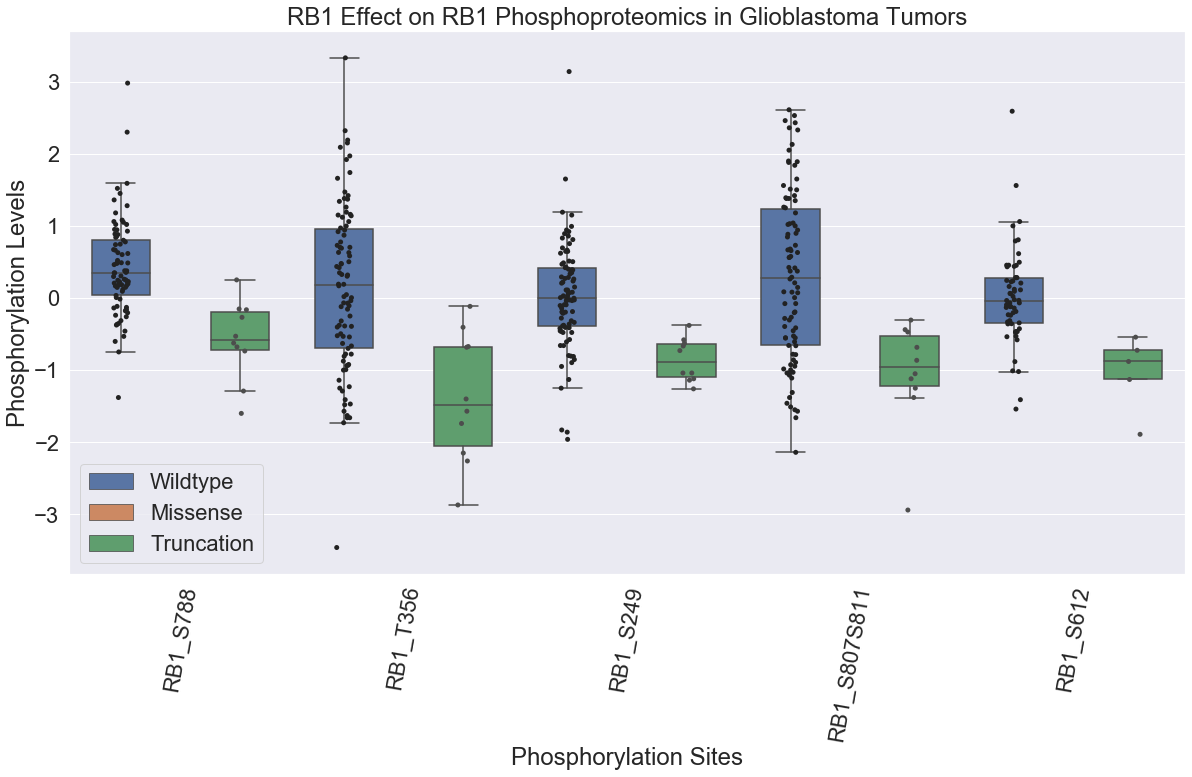

In [17]:
plt.rcParams['figure.figsize']=(20,10) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Glioblastoma Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = phos_cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])


plt.show()
plt.clf()
plt.close()

# Add CCNE1

In [18]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = "CCNE1")
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
only_phospho

Name,CCNE1_phosphoproteomics_S103_IIAPSRGS*PLPVLSWANR,CCNE1_phosphoproteomics_S387_AMLSEQNRAS*PLPSGLLTPPQSGK,CCNE1_phosphoproteomics_S391_AMLSEQNRASPLPS*GLLTPPQSGK
Sample_ID,,,
S001,NaN,-0.42500,NaN
S002,-0.705,NaN,NaN
S003,NaN,0.40600,1.50
S004,NaN,NaN,1.26
S005,NaN,-0.56600,NaN
...,...,...,...
S100,NaN,-0.00347,NaN
S101,-0.193,NaN,NaN
S102,-0.485,-0.50300,NaN


In [19]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
#phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status
1 significant comparisons!


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Comparison,P_Value
0,CCNE1_phosphoproteomics_S387_AMLSEQNRAS*PLPSGL...,8.092599e-07


In [20]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
#phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phospho_df_CCNE1 = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_CCNE1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_CCNE1.replace(to_replace = '.AMLSEQNRAS\WPLPSGLLTPPQSGK', value = '', 
                        inplace = True, regex = True)

phospho_df_CCNE1


,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,CCNE1_S387,-0.42500
1,Mutated,CCNE1_S387,NaN
2,Wildtype,CCNE1_S387,0.40600
3,Mutated,CCNE1_S387,NaN
4,Wildtype,CCNE1_S387,-0.56600
...,...,...,...
95,Wildtype,CCNE1_S387,-0.00347
96,Wildtype,CCNE1_S387,NaN
97,Wildtype,CCNE1_S387,-0.50300
98,Wildtype,CCNE1_S387,0.26900


In [21]:
phospho_df

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,RB1_S788,-0.678
1,Mutated,RB1_S788,-0.152
2,Wildtype,RB1_S788,-0.239
3,Mutated,RB1_S788,-0.625
4,Wildtype,RB1_S788,-0.178
...,...,...,...
495,Wildtype,RB1_S612,-0.426
496,Wildtype,RB1_S612,0.791
497,Wildtype,RB1_S612,-0.239
498,Wildtype,RB1_S612,-0.232


In [22]:
#phospho_df_CCNE1 = pd.melt(phospho_df, id_vars = ["specific_phospho", 'binary_mutations'], value_name = "omics")

phospho_df_CCNE1 = phospho_df.append(phospho_df_CCNE1)

phospho_df_CCNE1

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,RB1_S788,-0.67800
1,Mutated,RB1_S788,-0.15200
2,Wildtype,RB1_S788,-0.23900
3,Mutated,RB1_S788,-0.62500
4,Wildtype,RB1_S788,-0.17800
...,...,...,...
95,Wildtype,CCNE1_S387,-0.00347
96,Wildtype,CCNE1_S387,NaN
97,Wildtype,CCNE1_S387,-0.50300
98,Wildtype,CCNE1_S387,0.26900


# Add BRCA1

In [52]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = "BRCA1")
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
binary_phospho


Name,BRCA1_phosphoproteomics_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,BRCA1_phosphoproteomics_S114_ENNS*PEHLK,BRCA1_phosphoproteomics_S1164_EDTS*FAENDIK,BRCA1_phosphoproteomics_S1174_ESS*AVFSK,BRCA1_phosphoproteomics_S1187S1189S1191_GELS*RS*PS*PFTHTHLAQGYR,BRCA1_phosphoproteomics_S1187S1191_GELS*RSPS*PFTHTHLAQGYR,BRCA1_phosphoproteomics_S1189S1191_GELSRS*PS*PFTHTHLAQGYR,BRCA1_phosphoproteomics_S1189S1191_S*PS*PFTHTHLAQGYR,BRCA1_phosphoproteomics_S1191_SPS*PFTHTHLAQGYR,BRCA1_phosphoproteomics_S1217S1218_KLESSEENLS*S*EDEELPCFQHLLFGK,...,BRCA1_phosphoproteomics_S1342_ELVS*DDEER,BRCA1_phosphoproteomics_S1481_S*SEYPISQNPEGLSADK,BRCA1_phosphoproteomics_S1545_NYPS*QEELIK,BRCA1_phosphoproteomics_S1563_VVDVEEQQLEES*GPHDLTETSYLPR,BRCA1_phosphoproteomics_S1598_QDLEGTPYLESGISLFSDDPES*DPSEDRAPESAR,BRCA1_phosphoproteomics_S395S398_SDELLGS*DDS*HDGESESNAK,BRCA1_phosphoproteomics_S423_VADVLDVLNEVDEYS*GSSEK,BRCA1_phosphoproteomics_S425_VADVLDVLNEVDEYSGS*SEK,BRCA1_phosphoproteomics_S510_RRPTS*GLHPEDFIK,binary_mutations
Sample_ID,,,,,,,,,,,,,,,,,,,,,
S001,NaN,-0.3450,NaN,NaN,NaN,NaN,NaN,-0.022,-0.4230,NaN,...,NaN,1.4200,NaN,NaN,-0.170,NaN,NaN,NaN,NaN,Mutated
S002,NaN,0.0414,NaN,0.4580,NaN,NaN,NaN,NaN,-0.0219,NaN,...,NaN,1.8400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mutated
S003,NaN,-0.7510,NaN,-0.0688,NaN,NaN,NaN,NaN,0.5280,NaN,...,-0.55,NaN,NaN,NaN,NaN,0.136,NaN,NaN,NaN,Wildtype
S004,0.516,-0.4300,0.459,NaN,-0.0356,NaN,0.312,-0.334,0.1520,NaN,...,NaN,-0.0417,1.3600,NaN,NaN,NaN,0.646,NaN,NaN,Mutated
S005,NaN,-1.0200,NaN,NaN,NaN,NaN,NaN,0.520,-0.9870,NaN,...,NaN,-0.1700,NaN,NaN,-0.627,NaN,NaN,NaN,NaN,Wildtype
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S100,NaN,NaN,NaN,NaN,-0.2800,NaN,0.738,NaN,0.4980,NaN,...,NaN,1.0900,-0.0553,NaN,-1.440,NaN,NaN,NaN,NaN,Wildtype
S101,NaN,0.5220,NaN,NaN,NaN,NaN,NaN,0.894,0.3210,NaN,...,NaN,0.2900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wildtype
S102,NaN,-0.8390,NaN,NaN,NaN,NaN,NaN,NaN,0.3460,-0.344,...,NaN,0.2770,0.0506,NaN,NaN,NaN,NaN,NaN,NaN,Wildtype


In [46]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
#phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results

Doing t-test comparison for mutation status
No significant comparisons.


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [47]:
# Create data frame with all significant phospho sites in order to graph
#phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites
phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phospho_df_BRACA1 = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_BRACA1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_BRACA1.replace(to_replace = '.AMLSEQNRAS\WPLPSGLLTPPQSGK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRACA1.replace(to_replace = '.AMLSEQNRAS\WPLPSGLLTPPQSGK', value = '', 
                        inplace = True, regex = True)

phospho_df_BRACA1


,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,BRCA1_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,NaN
1,Mutated,BRCA1_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,NaN
2,Wildtype,BRCA1_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,NaN
3,Mutated,BRCA1_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,0.516
4,Wildtype,BRCA1_S1009_NLLEENFEEHSMS*PEREMGNENIPSTVSTISR,NaN
...,...,...,...
2095,Wildtype,BRCA1_S510_RRPTS*GLHPEDFIK,NaN
2096,Wildtype,BRCA1_S510_RRPTS*GLHPEDFIK,NaN
2097,Wildtype,BRCA1_S510_RRPTS*GLHPEDFIK,NaN
2098,Wildtype,BRCA1_S510_RRPTS*GLHPEDFIK,NaN


In [48]:
#phospho_df_CCNE1 = pd.melt(phospho_df, id_vars = ["specific_phospho", 'binary_mutations'], value_name = "omics")

phospho_df_CCNE1 = phospho_df.append(phospho_df_CCNE1)

phospho_df_CCNE1

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,RB1_S788,-0.67800
1,Mutated,RB1_S788,-0.15200
2,Wildtype,RB1_S788,-0.23900
3,Mutated,RB1_S788,-0.62500
4,Wildtype,RB1_S788,-0.17800
...,...,...,...
95,Wildtype,CCNE1_S387,-0.00347
96,Wildtype,CCNE1_S387,NaN
97,Wildtype,CCNE1_S387,-0.50300
98,Wildtype,CCNE1_S387,0.26900


In [55]:
phos = 'phosphoproteomics'

try:
    print("\nGene: ", gene)

    # Create dataframe in order to do comparisons with wrap_ttest
    phosdf = brain.join_omics_to_mutations(mutations_genes=[gene], 
                                           omics_genes= "BRCA1",
                                           omics_df_name=phos)
    phosdf = brain.reduce_multiindex(phosdf,levels_to_drop = 2, flatten = True)
    phosdf = phosdf.loc[phosdf['Sample_Status'] == 'Tumor']
    
    # Create the binary valued column needed to do the comparison
    for ind, row in phosdf.iterrows():
        if row[gene+"_Mutation_Status"] != 'Wildtype_Tumor':
            phosdf.at[ind,'Label'] = 'Mutated'
        else:
            phosdf.at[ind,'Label'] = 'Wildtype'

    # Format the datafram correctly'''
    phosdf = phosdf.drop(gene+"_Mutation",axis=1)
    phosdf = phosdf.drop(gene+"_Location",axis=1)
    phosdf = phosdf.drop(gene+"_Mutation_Status", axis=1)
    phosdf = phosdf.drop("Sample_Status",axis=1)

    # Make list of columns to be compared using t-tests
    phos_col_list = list(phosdf.columns)
    phos_col_list.remove('Label')
    
    print("Doing t-test comparisons\n")
    
    #Call wrap_ttest, pass in formatted dataframe
    phos_all_comparisons = wrap_ttest_return_all(phosdf, 'Label', phos_col_list)
    
    phos_num_comparisons = len(phos_col_list)
    print("Number of comparisons:", phos_num_comparisons)
    phos_bonferroni_cutoff = .05 / phos_num_comparisons
    print("Bonferroni cutoff = ", phos_bonferroni_cutoff)
            
        
except Exception as e:
    print("Error in Comparison")
    print(e)


Gene:  RB1
Error in Comparison
'BlockManager' object has no attribute 'T'


In [56]:
phos_all_comparisons = phos_all_comparisons.dropna(axis=0)
phos_sig_comparisons = phos_all_comparisons.loc[phos_all_comparisons['P_Value'] <= .05]
print("Number of significant Proteomics comparisons: ", len(phos_sig_comparisons),'\n')

if len(phos_sig_comparisons) > 0:
    print(phos_sig_comparisons)
phos_sig_comparisons

Number of significant Proteomics comparisons:  8 

                                          Comparison   P_Value
1  BRCA1_phosphoproteomics_S1217S1218_KLESSEENLS*...  0.002568
2       BRCA1_phosphoproteomics_S1336_HQSESQGVGLS*DK  0.004112
3  BRCA1_phosphoproteomics_S1187S1189S1191_GELS*R...  0.009532
4            BRCA1_phosphoproteomics_S1174_ESS*AVFSK  0.009876
5   BRCA1_phosphoproteomics_S1481_S*SEYPISQNPEGLSADK  0.010936
6            BRCA1_phosphoproteomics_S114_ENNS*PEHLK  0.020798
7          BRCA1_phosphoproteomics_S1545_NYPS*QEELIK  0.033077
8           BRCA1_phosphoproteomics_S1342_ELVS*DDEER  0.040128


,Comparison,P_Value
1,BRCA1_phosphoproteomics_S1217S1218_KLESSEENLS*...,0.002568
2,BRCA1_phosphoproteomics_S1336_HQSESQGVGLS*DK,0.004112
3,BRCA1_phosphoproteomics_S1187S1189S1191_GELS*R...,0.009532
4,BRCA1_phosphoproteomics_S1174_ESS*AVFSK,0.009876
5,BRCA1_phosphoproteomics_S1481_S*SEYPISQNPEGLSADK,0.010936
6,BRCA1_phosphoproteomics_S114_ENNS*PEHLK,0.020798
7,BRCA1_phosphoproteomics_S1545_NYPS*QEELIK,0.033077
8,BRCA1_phosphoproteomics_S1342_ELVS*DDEER,0.040128


In [85]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_sig_comparisons['Comparison']) # comment when no sig phospho sites
#phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phospho_df_BRCA1 = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_BRCA1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_BRCA1.replace(to_replace = '.KLESSEENLS\WS\WEDEELPCFQHLLFGK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.ELVS\WDDEER', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.ENNS\WPEHLK', value = '', 
                        inplace = True, regex = True)
                        
phospho_df_BRCA1.replace(to_replace = '.HQSESQGVGLS\WDK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.GELS\WRS\WPS\WPFTHTHLAQGYR', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.ESS\WAVFSK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.S\WSEYPISQNPEGLSADK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1.replace(to_replace = '.NYPS\WQEELIK', value = '', 
                        inplace = True, regex = True)
phospho_df_BRCA1


,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,BRCA1_S1217S1218,NaN
1,Mutated,BRCA1_S1217S1218,NaN
2,Wildtype,BRCA1_S1217S1218,NaN
3,Mutated,BRCA1_S1217S1218,NaN
4,Wildtype,BRCA1_S1217S1218,NaN
...,...,...,...
795,Wildtype,BRCA1_S1342,NaN
796,Wildtype,BRCA1_S1342,NaN
797,Wildtype,BRCA1_S1342,NaN
798,Wildtype,BRCA1_S1342,NaN


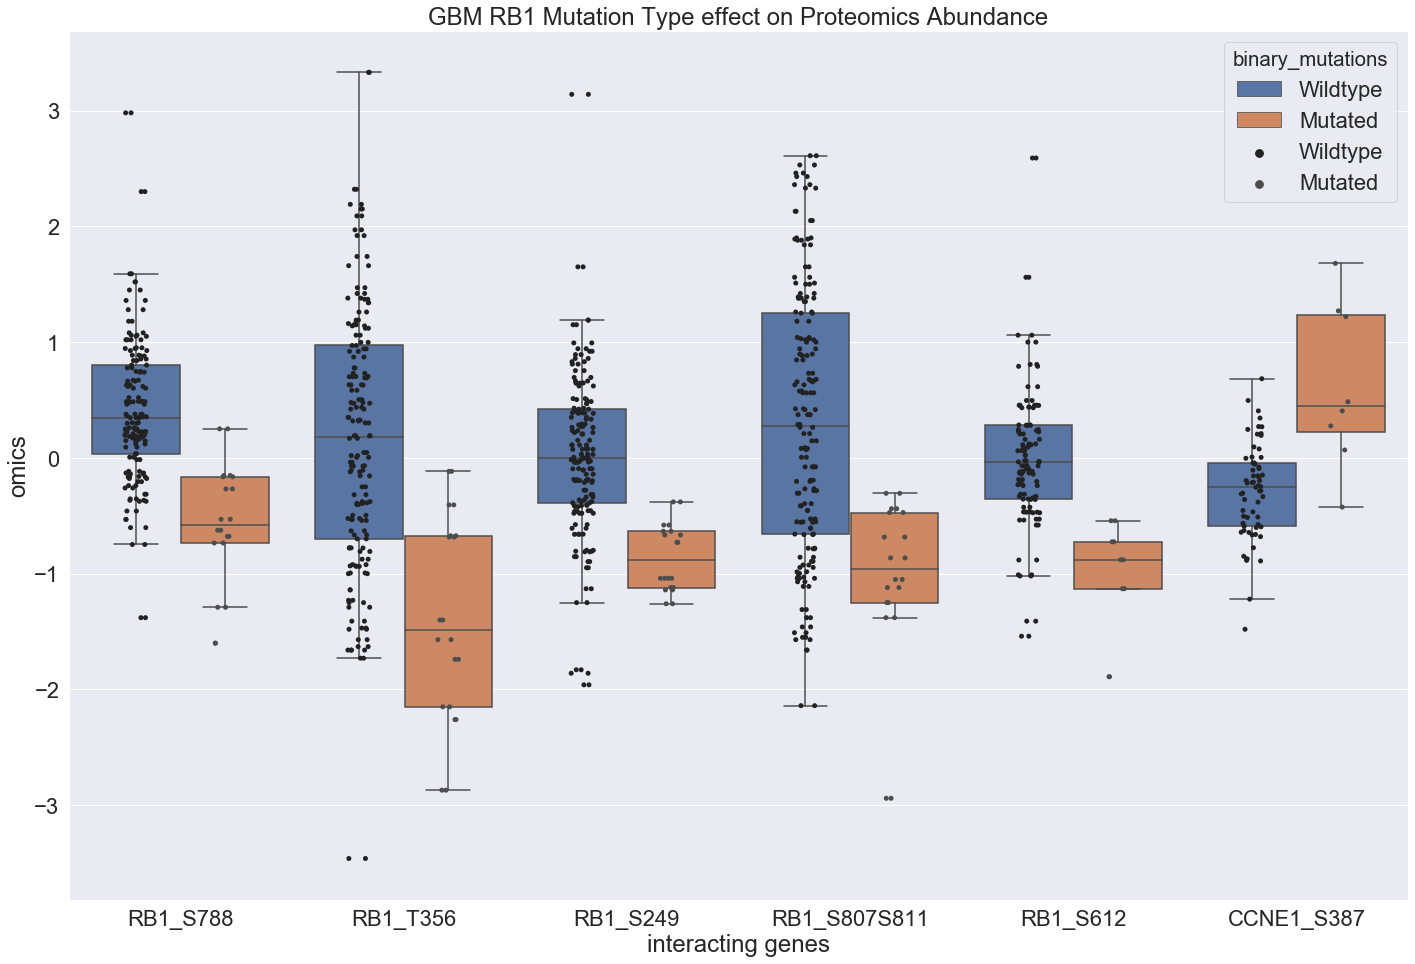

In [29]:
# Visualize
plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_CCNE1, showfliers = False)    
boxplot.set_title("GBM RB1 Mutation Type effect on Proteomics Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = phospho_df_CCNE1, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "interacting genes", ylabel = 'omics')

plt.show()
plt.clf()
plt.close()

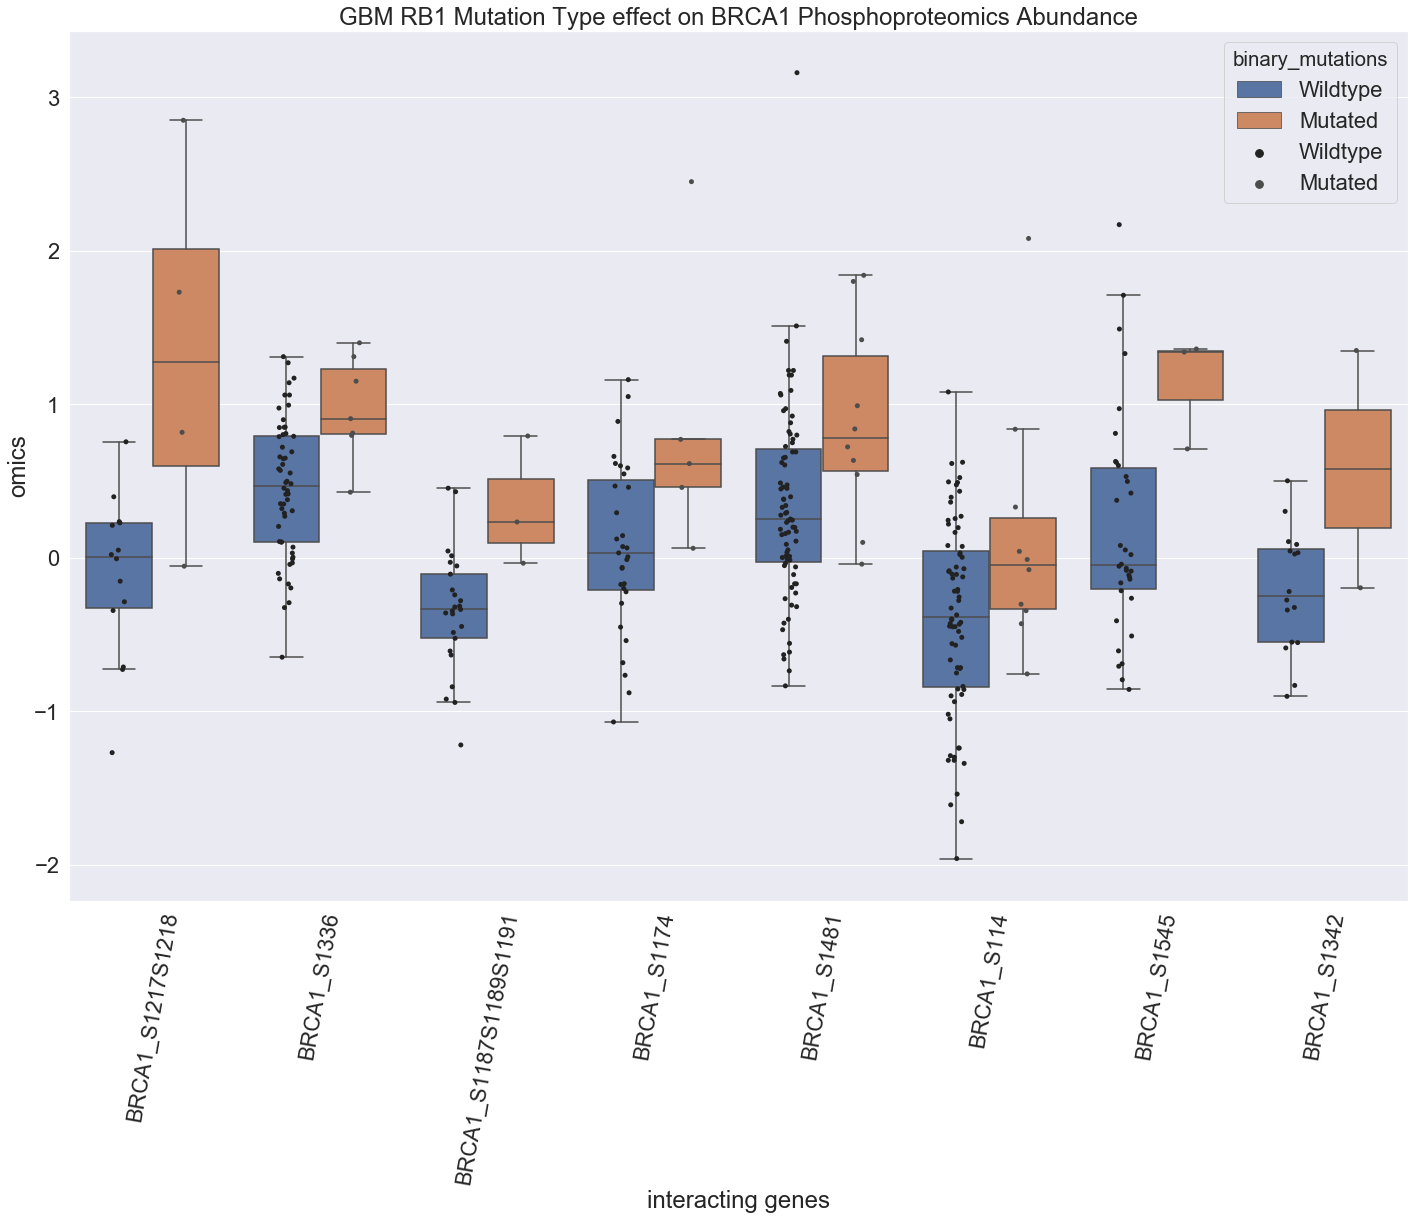

In [87]:
# Visualize
plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data = phospho_df_BRCA1, showfliers = False)    
boxplot.set_title("GBM RB1 Mutation Type effect on BRCA1 Phosphoproteomics Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = phospho_df_BRCA1, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "interacting genes", ylabel = 'omics')
boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)



plt.show()

plt.clf()
plt.close()

In [31]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = get_missense_truncation_comparison(brain, flatten_phospho_and_mut)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


In [32]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = u.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = u.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
phos_results_trunc

Doing t-test comparison for missense and wildtype

Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.
None


Doing t-test comparison for truncation and wildtype

No significant comparisons.


/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/Lindsey/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [33]:
# Create data frame with all significant phospho sites in order to graph
mut_type_phospho_list = list(phos_results_trunc['Comparison']) # comment when no sig phospho sites
#mut_type_phospho_list = list(only_phospho.columns) # uncomment when no sig phospho sites
phos_mut_type_df_CCNE1 = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = mut_type_phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df_CCNE1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phos_mut_type_df_CCNE1.replace(to_replace = '.AMLSEQNRAS\WPLPSGLLTPPQSGK', value = '', 
                        inplace = True, regex = True)
phos_mut_type_df_CCNE1

TypeError: 'NoneType' object is not subscriptable

In [ ]:
phospho_df_CCNE1 = phos_mut_type_df.append(phos_mut_type_df_CCNE1)



In [ ]:
plt.rcParams['figure.figsize']=(20,10) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phospho_df_CCNE1, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Glioblastoma Tumors")
phos_cis_boxplot = sns.stripplot(data = phospho_df_CCNE1, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = phos_cis_boxplot.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3])


plt.show()
plt.clf()
plt.close()

Acetylproteomics not included in the Gbm dataset.

In [ ]:
## mutation types on RB1
somatic_df = brain.get_somatic_mutation()
df1 = brain.join_omics_to_mutations(
    omics_df_name="proteomics",
    mutations_genes="RB1", 
    omics_genes=["RB1"])
df1.head(20)